In [1]:
import pandas as pd

df = pd.read_csv("training.1600000.processed.noemoticon.csv",encoding = "latin",header=None)
df = df.sample(50000)
df = df.iloc[:,[2,5,0]]
df.columns = ['datetime','text','class']
df['class'][df['class']==4] = 1
df.head()

,datetime,text,class
43703,Fri May 01 22:35:30 PDT 2009,LOL We just had an aftershock! What did Westla...,0
308095,Mon Jun 01 22:31:56 PDT 2009,I want to stay up for The Tonight Show!,0
323396,Tue Jun 02 09:18:25 PDT 2009,"Just come home from the beach, now having a fe...",0
177646,Fri May 29 16:26:23 PDT 2009,"@HimOverThere awww, poor leg! *sends virtual ...",0
1465586,Sun Jun 07 06:05:06 PDT 2009,Is on her way to the summertime ball.,1


In [2]:
sentiment = df.copy()
sentiment['datetime'] = pd.to_datetime(sentiment['datetime'], infer_datetime_format=True)
sentiment["date"] = sentiment['datetime'].dt.strftime("%Y-%m-%d")
sentiment["time"] = sentiment['datetime'].dt.strftime("%H:%M:%S %Z")

sentiment.head()

C:\Python39\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,datetime,text,class,date,time
43703,2009-05-01 22:35:30,LOL We just had an aftershock! What did Westla...,0,2009-05-01,22:35:30
308095,2009-06-01 22:31:56,I want to stay up for The Tonight Show!,0,2009-06-01,22:31:56
323396,2009-06-02 09:18:25,"Just come home from the beach, now having a fe...",0,2009-06-02,09:18:25
177646,2009-05-29 16:26:23,"@HimOverThere awww, poor leg! *sends virtual ...",0,2009-05-29,16:26:23
1465586,2009-06-07 06:05:06,Is on her way to the summertime ball.,1,2009-06-07,06:05:06


In [3]:
sentiment.shape, sentiment['class'].unique()

((50000, 5), array([0, 1], dtype=int64))

<AxesSubplot:xlabel='class', ylabel='count'>

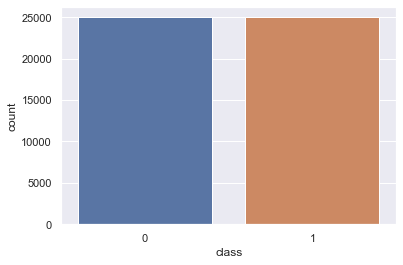

In [4]:
# Weekdays Effect on Mood
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
sns.countplot(x="class", data=sentiment)

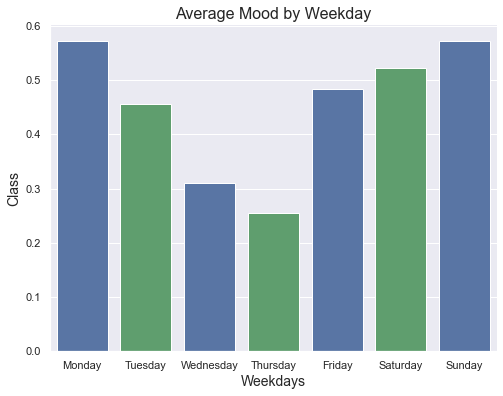

In [5]:
sentiment["weekday"] = sentiment['datetime'].dt.strftime("%A")

# create a grouped dataframe with the mean mood for each weekday
grouped = sentiment.groupby('weekday')['class'].mean().reset_index()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

custom_palette = ['#4c72b0', '#55a868']
plt.figure(figsize=(8,6))
sns.barplot(x='weekday', y='class', data=grouped, order=weekday_order, palette=custom_palette)
plt.ylabel('Class', fontsize=14)
plt.xlabel('Weekdays', fontsize=14)
plt.title('Average Mood by Weekday', fontsize=16)

sns.set_style('whitegrid')
sns.despine()

# show the plot
plt.show()

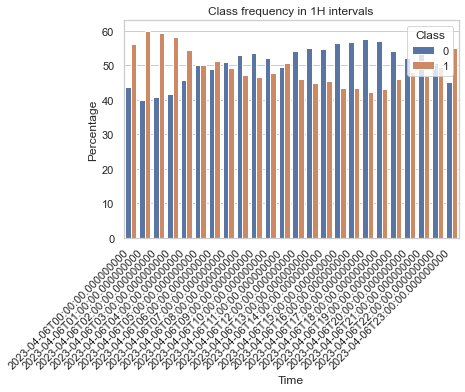

In [6]:
sentiment['time'] = pd.to_datetime(sentiment['time'])

# Group data into time intervals and calculate class frequency
interval = '1H'
time_grouped = sentiment.groupby(pd.Grouper(key='time', freq=interval))['class'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()

# Create bar plot using Seaborn
sns.set_style('whitegrid')
sns.barplot(data=time_grouped, x='time', y='percentage', hue='class')

# Add labels and legend
plt.title(f'Class frequency in {interval} intervals')
plt.xlabel('Time')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Class', loc='upper right')

# Display plot
plt.show()

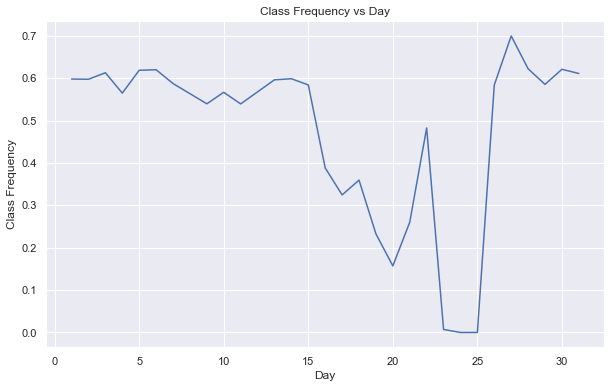

In [7]:
sentiment['date'] = pd.to_datetime(sentiment['date'], format='%Y-%m-%d')
sentiment["day"] = sentiment['date'].dt.day

# Grouping by month and computing the class frequency
monthly_class = sentiment.groupby("day")['class'].mean().reset_index()

# Creating a line plot using Matplotlib and Seaborn
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_class, x="day", y='class')
plt.title('Class Frequency vs Day')
plt.xlabel("Day")
plt.ylabel('Class Frequency')
plt.show()

In [8]:
# Prepare the Data
sentiment = df.copy()
sentiment['datetime'] = pd.to_datetime(sentiment['datetime'], infer_datetime_format=True)
sentiment["weekday"] = sentiment['datetime'].dt.strftime("%A")
sentiment["day"] = sentiment['datetime'].dt.strftime("%d").astype("int")
sentiment["time"] = sentiment['datetime'].dt.strftime("%H").astype("int")
sentiment = sentiment.drop("datetime", axis=1)

sentiment.head()

C:\Python39\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,text,class,weekday,day,time
43703,LOL We just had an aftershock! What did Westla...,0,Friday,1,22
308095,I want to stay up for The Tonight Show!,0,Monday,1,22
323396,"Just come home from the beach, now having a fe...",0,Tuesday,2,9
177646,"@HimOverThere awww, poor leg! *sends virtual ...",0,Friday,29,16
1465586,Is on her way to the summertime ball.,1,Sunday,7,6


In [9]:
from sklearn.model_selection import train_test_split

X = sentiment.drop("class", axis=1)
y = sentiment["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
import re

def tweet_to_plain_text(tweet):
    text = tweet.lower()  # lowercase
    text = re.sub(r'http://twitpic.com\S+', 'PIC', text)  # pic
    text = re.sub(r'http\S+', 'URL', text)  # URLs
    text = re.sub(r'@\w+', 'MENTION', text)  # mentions
    text = re.sub(r'#\w+', 'HASHTAG', text)  # hashtags
    text = re.sub('[^\w\s]','', text)  # punctuation
    text = re.sub('\d+', '', text)  # numbers
    text = text.strip()  # whitespace
    return text

In [11]:
negative_tweets = [tweet for tweet in X_train["text"][y_train==0]]
sample_negative_tweets = negative_tweets[7]
text = tweet_to_plain_text(sample_negative_tweets)
text

'up mad early for work meeting  i hate mornings lol'

In [12]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Error: stemming requires the NLTK module.


In [13]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
import numpy as np


class TweetToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, stemming=True):
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for tweet in X:
            text = tweet_to_plain_text(tweet) or ""
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [15]:
X_few = X_train["text"][:5]
X_few_wordcounts = TweetToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'in': 1, 'toronto': 1, 'free': 1, 'wifi': 1, 'is': 1, 'everywhere': 1, 'i': 1, 'like': 1, 'it': 1}),
       Counter({'to': 2, 'not': 1, 'ready': 1, 'take': 1, 'you': 1, 'the': 1, 'airport': 1}),
       Counter({'MENTION': 1, 'hahaha': 1, 'baca': 1, 'aja': 1, 'status': 1, 'update': 1, 'gue': 1, 'yg': 1, 'sebelumnya': 1}),
       Counter({'MENTION': 1, 'mate': 1, 'one': 1, 'of': 1, 'the': 1, 'original': 1, 'tools': 1, 'for': 1, 'building': 1, 'social': 1, 'networks': 1, 'in': 1, 'south': 1, 'america': 1, 'URL': 1}),
       Counter({'MENTION': 1, 'you': 1, 'will': 1, 'always': 1, 'be': 1, 'bf': 1, 'in': 1, 'my': 1, 'heart': 1, 'lol': 1})],
      dtype=object)

In [16]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1)).toarray()

In [17]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

array([[ 3,  1,  0,  0,  0,  0,  1,  1,  1,  1,  1],
       [ 4,  0,  0,  2,  1,  1,  0,  0,  0,  0,  0],
       [ 8,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [12,  1,  1,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 7,  1,  1,  0,  1,  0,  0,  0,  0,  0,  0]], dtype=int32)

In [18]:
vocab_transformer.vocabulary_

{'in': 1,
 'MENTION': 2,
 'to': 3,
 'you': 4,
 'the': 5,
 'toronto': 6,
 'free': 7,
 'wifi': 8,
 'is': 9,
 'everywhere': 10}

In [19]:
# since sklearn doesn't handle dataframes yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names, squeeze=False):
        self.attribute_names = attribute_names
        self.squeeze = squeeze
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.squeeze:
            return X[self.attribute_names].squeeze()
        return X[self.attribute_names]


In [20]:
from sklearn.pipeline import Pipeline
text_pipeline = Pipeline([
    ("select_tweet", DataFrameSelector(["text"], squeeze=True)),
    ("tweet_to_wordcount", TweetToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

text_pipeline.fit_transform(X_train).shape

(40000, 1001)

In [21]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["weekday"])),
    ("cat_encoder", OneHotEncoder(sparse=False)),
])

cat_pipeline.fit_transform(X_train).shape

(40000, 7)

In [22]:
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("select_num", DataFrameSelector(["time", "day"])),
    ("scale", StandardScaler())
])

num_pipeline.fit_transform(X_train).shape

(40000, 2)

In [23]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
    ('text_pipeline', text_pipeline),
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [24]:
X_train_transformed

array([[ 3.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  1.],
       [ 6.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [10.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.]])

In [25]:
# Model traning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.766) total time=   1.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ................................ score: (test=0.765) total time=   1.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV] END ................................ score: (test=0.763) total time=   1.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.6s finished


0.7646499659566635

In [26]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))


Precision: 75.89%
Recall: 78.86%
